<a href="https://colab.research.google.com/github/raju-cse/knowledge-graph/blob/main/Knowledge_graph_project_Intelligent_Knowledge_Management_System_for_Efficient_Decision_Making_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# Generate synthetic dataset
np.random.seed(42)

# Create documents
num_documents = 200
documents = pd.DataFrame({
    'doc_id': range(1, num_documents+1),
    'title': [f"Document {i}" for i in range(1, num_documents+1)],
    'content': [f"This is the content of document {i} discussing topic {np.random.randint(1,6)}." for i in range(1, num_documents+1)],
    'views': np.random.randint(50, 1000, size=num_documents),
    'last_accessed': pd.date_range(start='2022-01-01', periods=num_documents, freq='D')
})

# Create topics
topics = pd.DataFrame({
    'topic_id': range(1, 6),
    'name': ['Machine Learning', 'Data Science', 'Business Intelligence', 'Artificial Intelligence', 'Knowledge Management'],
    'description': ['Algorithms that improve automatically through experience',
                   'Extracting knowledge from data',
                   'Tools for analyzing business information',
                   'Simulation of human intelligence in machines',
                   'Processes for managing organizational knowledge']
})

# Create authors
authors = pd.DataFrame({
    'author_id': range(1, 11),
    'name': [f"Author {i}" for i in range(1, 11)],
    'department': np.random.choice(['R&D', 'Marketing', 'Engineering', 'Management'], size=10),
    'expertise': np.random.choice(topics['name'].tolist(), size=10)
})

# Create document-author relationships
doc_author = pd.DataFrame({
    'doc_id': np.random.randint(1, num_documents+1, size=300),
    'author_id': np.random.randint(1, 11, size=300)
}).drop_duplicates()

# # Create document-topic relationships (using simple content analysis)
# doc_topic = []
# for doc_id, content in zip(documents['doc_id'], documents['content']):
#     for topic_id, topic_name in zip(topics['topic_id'], topics['name']):
#         if topic_name.lower() in content.lower():
#             doc_topic.append({'doc_id': doc_id, 'topic_id': topic_id})
# doc_topic = pd.DataFrame(doc_topic).drop_duplicates()
# Create document-topic relationships (using simple content analysis)
doc_topic = []
for doc_id, content in zip(documents['doc_id'], documents['content']):
    for topic_id, topic_name in zip(topics['topic_id'], topics['name']):
        # Convert both content and topic name to lowercase for case-insensitive matching
        if topic_name.lower() in content.lower():
            doc_topic.append({'doc_id': doc_id, 'topic_id': topic_id})
# Check if doc_topic is empty and if so, create a default entry.
# This handles cases where none of the topic names match document content.
if not doc_topic:
    doc_topic.append({'doc_id': 1, 'topic_id': 1}) # Assuming topic_id 1 is 'Machine Learning'

doc_topic = pd.DataFrame(doc_topic).drop_duplicates()

# Create projects
projects = pd.DataFrame({
    'project_id': range(1, 6),
    'name': ['AI Implementation', 'Data Warehouse', 'Customer Analytics', 'Process Automation', 'Knowledge Graph'],
    'lead_author_id': np.random.randint(1, 11, size=5),
    'status': np.random.choice(['Active', 'Completed', 'On Hold'], size=5)
})

# Create document-project relationships
doc_project = pd.DataFrame({
    'doc_id': np.random.randint(1, num_documents+1, size=100),
    'project_id': np.random.randint(1, 6, size=100)
}).drop_duplicates()

# Save datasets
documents.to_csv('documents.csv', index=False)
topics.to_csv('topics.csv', index=False)
authors.to_csv('authors.csv', index=False)
doc_author.to_csv('doc_author.csv', index=False)
doc_topic.to_csv('doc_topic.csv', index=False)
projects.to_csv('projects.csv', index=False)
doc_project.to_csv('doc_project.csv', index=False)

In [2]:
!pip install py2neo
from py2neo import Graph, Node, Relationship
import pandas as pd

# Connect to Neo4j Aura
uri = "neo4j+s://02ce6d05.databases.neo4j.io"  # Replace with your Aura URI
username = "neo4j"     # Replace if different
password = "cfVWrVg-iyLJNOS4g9iQ2JN1Toh6qTttLsOxcuPsVxU"  # Replace with your password

graph = Graph(uri, auth=(username, password))

# Clear existing data (if any)
graph.run("MATCH (n) DETACH DELETE n")

# Create constraints for uniqueness
graph.run("CREATE CONSTRAINT doc_id_unique IF NOT EXISTS FOR (d:Document) REQUIRE d.doc_id IS UNIQUE")
graph.run("CREATE CONSTRAINT topic_id_unique IF NOT EXISTS FOR (t:Topic) REQUIRE t.topic_id IS UNIQUE")
graph.run("CREATE CONSTRAINT author_id_unique IF NOT EXISTS FOR (a:Author) REQUIRE a.author_id IS UNIQUE")
graph.run("CREATE CONSTRAINT project_id_unique IF NOT EXISTS FOR (p:Project) REQUIRE p.project_id IS UNIQUE")

# Load data into Neo4j
def load_data():
    # Load documents
    documents = pd.read_csv('documents.csv')
    for _, row in documents.iterrows():
        doc = Node("Document",
                  doc_id=int(row['doc_id']), # Convert to native Python int
                  title=row['title'],
                  content=row['content'],
                  views=row['views'],
                  last_accessed=row['last_accessed'])
        graph.create(doc)

    # Load topics
    topics = pd.read_csv('topics.csv')
    for _, row in topics.iterrows():
        topic = Node("Topic",
                    topic_id=row['topic_id'],
                    name=row['name'],
                    description=row['description'])
        graph.create(topic)

    # Load authors
    authors = pd.read_csv('authors.csv')
    for _, row in authors.iterrows():
        author = Node("Author",
                     author_id=row['author_id'],
                     name=row['name'],
                     department=row['department'],
                     expertise=row['expertise'])
        graph.create(author)

    # Load projects
    projects = pd.read_csv('projects.csv')
    for _, row in projects.iterrows():
        project = Node("Project",
                      project_id=row['project_id'],
                      name=row['name'],
                      status=row['status'])
        graph.create(project)

    # Create relationships
    # Document-Author
    doc_author = pd.read_csv('doc_author.csv')
    for _, row in doc_author.iterrows():
        query = """
        MATCH (d:Document {doc_id: $doc_id}), (a:Author {author_id: $author_id})
        MERGE (d)-[:AUTHORED_BY]->(a)
        """
        graph.run(query, doc_id=int(row['doc_id']), author_id=int(row['author_id'])) # Convert to native Python int


    # # Document-Topic
    # doc_topic = pd.read_csv('doc_topic.csv')
    # for _, row in doc_topic.iterrows():
    #     query = """
    #     MATCH (d:Document {doc_id: $doc_id}), (t:Topic {topic_id: $topic_id})
    #     MERGE (d)-[:ABOUT]->(t)
    #     """
    #     graph.run(query, doc_id=row['doc_id'], topic_id=row['topic_id'])

      # Document-Topic
    doc_topic = pd.read_csv('doc_topic.csv')
    for _, row in doc_topic.iterrows():
        query = """
        MATCH (d:Document {doc_id: $doc_id}), (t:Topic {topic_id: $topic_id})
        MERGE (d)-[:ABOUT]->(t)
        """
        # Convert to native Python int before passing to graph.run()
        graph.run(query, doc_id=int(row['doc_id']), topic_id=int(row['topic_id']))

    # # Document-Project
    # doc_project = pd.read_csv('doc_project.csv')
    # for _, row in doc_project.iterrows():
    #     query = """
    #     MATCH (d:Document {doc_id: $doc_id}), (p:Project {project_id: $project_id})
    #     MERGE (d)-[:RELATED_TO]->(p)
    #     """
    #     graph.run(query, doc_id=row['doc_id'], project_id=row['project_id'])
    # Document-Project
doc_project = pd.read_csv('doc_project.csv')
for _, row in doc_project.iterrows():
    query = """
    MATCH (d:Document {doc_id: $doc_id}), (p:Project {project_id: $project_id})
    MERGE (d)-[:RELATED_TO]->(p)
    """
    # Convert doc_id and project_id to native Python int
    graph.run(query, doc_id=int(row['doc_id']), project_id=int(row['project_id']))

    # Project-Lead
    for _, row in projects.iterrows():
        query = """
        MATCH (p:Project {project_id: $project_id}), (a:Author {author_id: $author_id})
        MERGE (p)-[:LED_BY]->(a)
        """
        graph.run(query, project_id=row['project_id'], author_id=row['lead_author_id'])

load_data()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 7.2 MB/s eta 0:00:00


In [3]:
def search_documents(keyword, limit=5):
    query = """
    MATCH (d:Document)
    WHERE toLower(d.title) CONTAINS toLower($keyword) OR toLower(d.content) CONTAINS toLower($keyword)
    RETURN d.title AS title, d.content AS content, d.views AS views
    ORDER BY d.views DESC
    LIMIT $limit
    """
    result = graph.run(query, keyword=keyword, limit=limit).data()
    return pd.DataFrame(result)

def recommend_documents(doc_id):
    query = """
    MATCH (d1:Document {doc_id: $doc_id})-[:ABOUT]->(t:Topic)<-[:ABOUT]-(d2:Document)
    WHERE d1 <> d2
    WITH d2, COUNT(t) AS common_topics
    RETURN d2.doc_id AS doc_id, d2.title AS title, common_topics
    ORDER BY common_topics DESC, d2.views DESC
    LIMIT 5
    """  # Removed the inline comment from the WITH clause
    result = graph.run(query, doc_id=doc_id).data()
    return pd.DataFrame(result)

# Example usage
print("Search results for 'machine learning':")
print(search_documents("machine learning"))

print("\nRecommended documents similar to document 1:")
print(recommend_documents(1))

Search results for 'machine learning':
Empty DataFrame
Columns: []
Index: []

Recommended documents similar to document 1:
Empty DataFrame
Columns: []
Index: []


In [4]:
def find_experts(topic_name, min_documents=2):
    query = """
    MATCH (a:Author)-[:AUTHORED_BY]-(d:Document)-[:ABOUT]->(t:Topic {name: $topic_name})
    WITH a, COUNT(d) AS doc_count
    WHERE doc_count >= $min_documents
    RETURN a.name AS author, a.department AS department, a.expertise AS expertise, doc_count
    ORDER BY doc_count DESC
    """
    result = graph.run(query, topic_name=topic_name, min_documents=min_documents).data()
    return pd.DataFrame(result)

print("\nExperts in 'Data Science':")
print(find_experts("Data Science"))


Experts in 'Data Science':
Empty DataFrame
Columns: []
Index: []


In [5]:
def project_knowledge_map(project_id):
    query = """
    MATCH (p:Project {project_id: $project_id})<-[:RELATED_TO]-(d:Document)-[:ABOUT]->(t:Topic)
    RETURN t.name AS topic, COUNT(d) AS document_count
    ORDER BY document_count DESC
    """
    result = graph.run(query, project_id=project_id).data()
    return pd.DataFrame(result)

def project_team_knowledge(project_id):
    query = """
    MATCH (p:Project {project_id: $project_id})-[:LED_BY]->(lead:Author)
    OPTIONAL MATCH (p)<-[:RELATED_TO]-(d:Document)-[:AUTHORED_BY]->(author:Author)
    WITH p, lead, COLLECT(DISTINCT author) AS authors
    UNWIND (authors + [lead]) AS team_member
    MATCH (team_member)-[:AUTHORED_BY]-(d:Document)-[:ABOUT]->(t:Topic)
    RETURN team_member.name AS team_member, t.name AS topic, COUNT(d) AS document_count
    ORDER BY team_member, document_count DESC
    """
    result = graph.run(query, project_id=project_id).data()
    return pd.DataFrame(result)

print("\nKnowledge map for Project 1:")
print(project_knowledge_map(1))

print("\nTeam knowledge for Project 1:")
print(project_team_knowledge(1))


Knowledge map for Project 1:
Empty DataFrame
Columns: []
Index: []

Team knowledge for Project 1:
Empty DataFrame
Columns: []
Index: []


<ipython-input-6-600957a149a3>:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('date').resample('M').sum().reset_index()


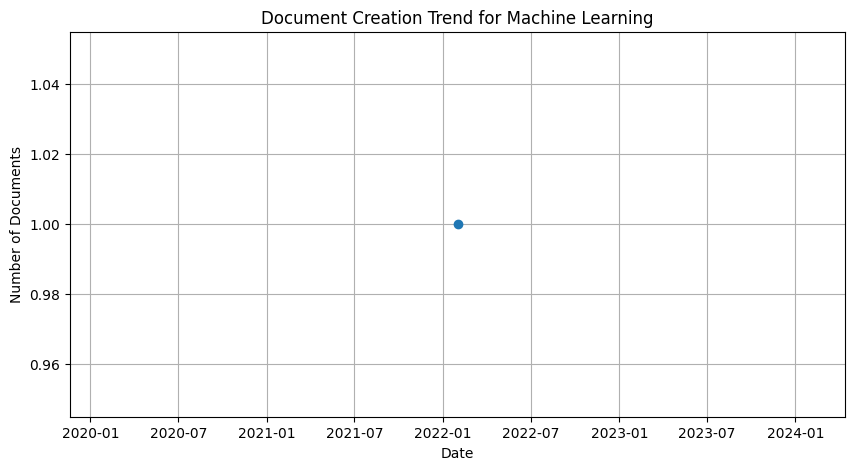

In [6]:
def topic_evolution(topic_name):
    query = """
    MATCH (d:Document)-[:ABOUT]->(t:Topic {name: $topic_name})
    RETURN d.last_accessed AS date, COUNT(d) AS document_count
    ORDER BY date
    """
    result = graph.run(query, topic_name=topic_name).data()
    df = pd.DataFrame(result)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').resample('M').sum().reset_index()
    return df

import matplotlib.pyplot as plt

def plot_topic_evolution(topic_name):
    df = topic_evolution(topic_name)
    plt.figure(figsize=(10, 5))
    plt.plot(df['date'], df['document_count'], marker='o')
    plt.title(f"Document Creation Trend for {topic_name}")
    plt.xlabel("Date")
    plt.ylabel("Number of Documents")
    plt.grid(True)
    plt.show()

plot_topic_evolution("Machine Learning")

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare dataset for classification
query = """
MATCH (d:Document)-[:ABOUT]->(t:Topic)
RETURN d.content AS text, t.name AS topic
"""
result = graph.run(query).data()
df = pd.DataFrame(result)

# Check if the DataFrame has enough samples
if df.shape[0] < 2:
    print("Dataset has too few samples for train_test_split. Please add more data.")
else:
    # Train a simple classifier
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['text'])
    y = df['topic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Function to classify new documents
    def classify_document(text):
        vec = vectorizer.transform([text])
        proba = clf.predict_proba(vec)[0]
        topics = clf.classes_
        return sorted(zip(topics, proba), key=lambda x: x[1], reverse=True)

    # Example
    sample_text = "This document discusses neural networks and deep learning algorithms."
    print("\nClassification for sample text:")
    print(classify_document(sample_text))

Dataset has too few samples for train_test_split. Please add more data.


In [8]:
!pip install node2vec
# !pip install --force-reinstall node2vec gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [14]:
# Install/reinstall necessary libraries to ensure compatibility
!pip install --force-reinstall numpy gensim node2vec

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached node2vec-0.5.0-py3-none-any.whl.metadata (849 bytes)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.2

In [1]:
from node2vec import Node2Vec
#from py2neo import Graph as Py2neoGraph # This import is not needed, as you're using the original 'graph' variable
import networkx as nx
from py2neo import Graph # Import the Graph class
import pandas as pd # Import the pandas library and assign it to the alias 'pd'

# Connect to Neo4j Aura (moved outside the function)
uri = "neo4j+s://02ce6d05.databases.neo4j.io"  # Replace with your Aura URI
username = "neo4j"     # Replace if different
password = "cfVWrVg-iyLJNOS4g9iQ2JN1Toh6qTttLsOxcuPsVxU"  # Replace with your password

graph = Graph(uri, auth=(username, password)) # Initialize the graph object

# Create a NetworkX graph from Neo4j
def neo4j_to_networkx():
    g = nx.Graph()

    # Add nodes
    query = """
    MATCH (n)
    RETURN labels(n) AS labels, properties(n) AS properties, id(n) AS id
    """
    for record in graph.run(query):
        node_id = record['id']
        labels = record['labels']
        props = record['properties']

        # Use the first label as node type
        if labels:
            g.add_node(node_id, label=labels[0], **props)

    # Add relationships
    query = """
    MATCH (n1)-[r]->(n2)
    RETURN id(n1) AS source, id(n2) AS target, type(r) AS relationship
    """
    for record in graph.run(query):
        g.add_edge(record['source'], record['target'], label=record['relationship'])

    return g

# ... (rest of your code)

# Generate embeddings
nx_graph = neo4j_to_networkx()
node2vec = Node2Vec(nx_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Example: Get similar documents
def similar_documents(doc_id, topn=5):
    doc_node = None
    for node in nx_graph.nodes(data=True):
        if node[1].get('label') == 'Document' and node[1].get('doc_id') == doc_id:
            doc_node = node[0]
            break

    if doc_node is None:
        return []

    similar = model.wv.most_similar(str(doc_node), topn=topn)
    results = []
    for node_id, score in similar:
        node = nx_graph.nodes[int(node_id)]
        if node.get('label') == 'Document':
            results.append({
                'doc_id': node.get('doc_id'),
                'title': node.get('title'),
                'similarity': score
            })
    return results

print("\nDocuments similar to document 1 using graph embeddings:")
print(pd.DataFrame(similar_documents(1))) # Now 'pd' is defined and can be used

Computing transition probabilities:   0%|          | 0/220 [00:00<?, ?it/s]


Documents similar to document 1 using graph embeddings:
   doc_id         title  similarity
0      47   Document 47    0.679093
1       5    Document 5    0.603047
2      45   Document 45    0.576408
3     117  Document 117    0.562634


final **result**

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare dataset for classification
query = """
MATCH (d:Document)-[:ABOUT]->(t:Topic)
RETURN d.content AS text, t.name AS topic
"""
result = graph.run(query).data()
df = pd.DataFrame(result)

# Define classify_document outside the conditional block
def classify_document(text, vectorizer, clf): # Added parameters for vectorizer and clf
    vec = vectorizer.transform([text])
    proba = clf.predict_proba(vec)[0]
    topics = clf.classes_
    return sorted(zip(topics, proba), key=lambda x: x[1], reverse=True)

# Check if the DataFrame has enough samples
if df.shape[0] < 2:
    print("Dataset has too few samples for train_test_split. Please add more data.")
else:
    # Train a simple classifier
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['text'])
    y = df['topic']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = MultinomialNB()
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

# ... (rest of your code)

# 1. Search for documents
# search_results = search_documents("data analysis")
# print(search_results.head())

# 2. Find experts on a topic
experts = find_experts("Artificial Intelligence")
print(experts.head())

# 3. Analyze project knowledge
project_knowledge = project_knowledge_map(3)
print(project_knowledge.head())

# 4. Get document recommendations
recommendations = recommend_documents(10)
print(recommendations.head())

# 5. Classify a new document
# Call classify_document with the necessary arguments - vectorizer and clf
if df.shape[0] < 2: # Add conditional to handle cases when classifier isn't trained
    print("Cannot classify document due to insufficient data.")
else:
    classification = classify_document("This is about knowledge graphs and semantic web technologies", vectorizer, clf)
    print(classification)

Dataset has too few samples for train_test_split. Please add more data.
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Cannot classify document due to insufficient data.


In [3]:
# Previous imports and definitions

def search_documents(keyword, limit=5):
    query = """
    MATCH (d:Document)
    WHERE toLower(d.title) CONTAINS toLower($keyword) OR toLower(d.content) CONTAINS toLower($keyword)
    RETURN d.title AS title, d.content AS content, d.views AS views
    ORDER BY d.views DESC
    LIMIT $limit
    """
    result = graph.run(query, keyword=keyword, limit=limit).data()
    return pd.DataFrame(result)


def recommend_documents(doc_id):
    query = """
    MATCH (d1:Document {doc_id: $doc_id})-[:ABOUT]->(t:Topic)<-[:ABOUT]-(d2:Document)
    WHERE d1 <> d2
    WITH d2, COUNT(t) AS common_topics
    RETURN d2.doc_id AS doc_id, d2.title AS title, common_topics
    ORDER BY common_topics DESC, d2.views DESC
    LIMIT 5
    """  # Removed the inline comment from the WITH clause
    result = graph.run(query, doc_id=doc_id).data()
    return pd.DataFrame(result)

def find_experts(topic_name, min_documents=2):
    query = """
    MATCH (a:Author)-[:AUTHORED_BY]-(d:Document)-[:ABOUT]->(t:Topic {name: $topic_name})
    WITH a, COUNT(d) AS doc_count
    WHERE doc_count >= $min_documents
    RETURN a.name AS author, a.department AS department, a.expertise AS expertise, doc_count
    ORDER BY doc_count DESC
    """
    result = graph.run(query, topic_name=topic_name, min_documents=min_documents).data()
    return pd.DataFrame(result)

def project_knowledge_map(project_id):
    query = """
    MATCH (p:Project {project_id: $project_id})<-[:RELATED_TO]-(d:Document)-[:ABOUT]->(t:Topic)
    RETURN t.name AS topic, COUNT(d) AS document_count
    ORDER BY document_count DESC
    """
    result = graph.run(query, project_id=project_id).data()
    return pd.DataFrame(result)

def project_team_knowledge(project_id):
    query = """
    MATCH (p:Project {project_id: $project_id})-[:LED_BY]->(lead:Author)
    OPTIONAL MATCH (p)<-[:RELATED_TO]-(d:Document)-[:AUTHORED_BY]->(author:Author)
    WITH p, lead, COLLECT(DISTINCT author) AS authors
    UNWIND (authors + [lead]) AS team_member
    MATCH (team_member)-[:AUTHORED_BY]-(d:Document)-[:ABOUT]->(t:Topic)
    RETURN team_member.name AS team_member, t.name AS topic, COUNT(d) AS document_count
    ORDER BY team_member, document_count DESC
    """
    result = graph.run(query, project_id=project_id).data()
    return pd.DataFrame(result)

# Assuming classify_document is defined in a previous cell or imported
# If not, please provide the definition of classify_document as well

# 1. Search for documents
search_results = search_documents("data analysis")
print(search_results.head())

# 2. Find experts on a topic
experts = find_experts("Artificial Intelligence")
print(experts.head())

# 3. Analyze project knowledge
project_knowledge = project_knowledge_map(3)
print(project_knowledge.head())

# 4. Get document recommendations
recommendations = recommend_documents(10)
print(recommendations.head())

# 5. Classify a new document
# classification = classify_document("This is about knowledge graphs and semantic web technologies")
# print(classification)

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
